# Auto-Differentiation From Scratch
> Written by Nick Stanisha, Ryan Soklaski, and David Mascharka

In this assignment, you will be writing your own auto-differentiation package from scratch. To complete this assignment you will need to understand

* Classes and methods (Python Module 5)
* Partial derivatives, the chain rule, and back propagation therein.

After completing this assignment, you will have created software that is capable of finding the gradient of any composite function that uses your operations. Along the way, you will employ similar techniques to what are used to create libraries like [Tensorflow](https://www.tensorflow.org/) and [PyTorch](http://pytorch.org/). Your specific implementation will be most similar to PyTorch.

Recall the computational graph that we studied in the reading

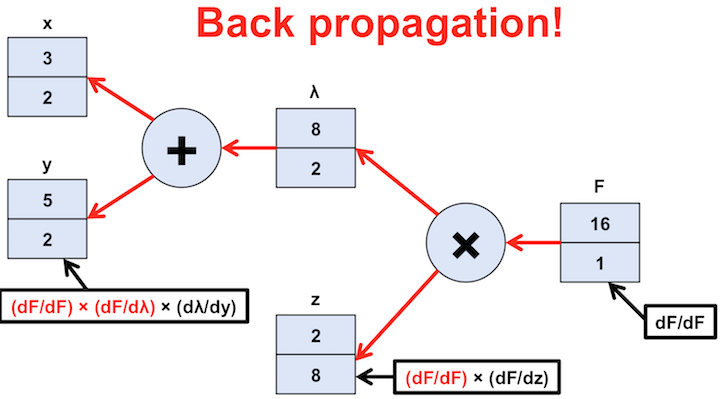

We will define the class `Number` and subclasses of `Operation` so that we can easily implement this, and any other computational graph, in Python. Using your auto-differentiation package, we will be able to reimplement the above graph as follows:

```python
# Initializing the independent variables using our class `Number`
>>> x = Number(3)
>>> y = Number(5)
>>> z = Number(2)

# Defining the graph..
# Invoking '+' here actually uses `Add`, our subclass of `Operation`
>>> lmbd = x + y
>>> lmbd
Number(8)

# invoking '*' here uses `Multiply`, our subclass of `Operation`
>>> F = lmbd * z
>>> F
Number(16)

# all gradient-components are `None` prior to us invoking back-propagation
>>> x.grad is None
True

# perform backprop, starting from F
# computes all partial derivatives of F
>>> F.backprop()

>>> F.grad  # dF/dF
1

>>> lmbd.grad  # dF/d(lmbd)
2

>>> z.grad  # dF/dz
8

>>> x.grad  # dF/dx
2

>>> y.grad  # dF/dy
2
```

This package is extremely powerful - you can compute the numerical values of derivatives for a variable that is involved in extremely complicated computational graphs, simply by invoking `F.backprop()`! You could even use it to help check your Calculus homework :) We will accomplish this by ensuring that our implementations of `Number` and `Operation` carry out the multivariable chain rule faithfully.

To be clear, suppose we encounter the computational graph:

```python
x = Numeric(2.5)
y = Numeric(-1.5)

p = 3*x*y
q = x**2 - y

F = x*(p + 2*q)
F.backward()
```

Here, invoking `F.backward()` informs our package to immediately compute the total derivatives $\frac{dF}{dF}$, $\frac{dF}{dq}$, $\frac{dF}{dp}$, $\frac{dF}{dy}$, and $\frac{dF}{dx}$, all evaluated using $x = 2.5$ and $y = -1.5$. Where, for instance, $\frac{dF}{dx}$ is:

\begin{equation}
\frac{dF}{dx} = \frac{\partial F}{\partial x} + \frac{\partial F}{\partial p}\frac{\partial p}{\partial x} + \frac{\partial F}{\partial q}\frac{\partial q}{\partial x} = (p + 2q) + x(3y) + 2x(2x) = 18.0
\end{equation}

Thus `x.grad` returns 18.0. If this calculation did not make sense, please review the supplemental material for this module.

# Beginning of Assignment

In [ ]:
%load_ext autoreload
%autoreload 2

# RUN ME!

import numpy as np
from bwsi_grader.cogworks.autograd import grade_op, grade_arithmetic
from bwsi_grader.cogworks.autograd import grade_backprop, grade_op_backprop
from operations import Add, Subtract, Multiply, Divide, Power

## Part 1(a) - Wrapping addition and multiplication

If you have not already done so, please work through Python Module 5: Object Oriented Programming.

In order for people to easily use your library, you must provide an unobtrusive layer of abstraction for basic arithmetic. Examine the `Number` class below, which represents a scalar quantity (i.e. a single number). All of the class' special methods, e.g. `__add__`, conveniently overwrite operators like `+`, `*`, etc. Making the following code possible

```python
>>> a, b = Number(1), Number(2)
>>> a + b
Number(3)
>>> a * b
Number(2)
>>> a + 15
Number(16)
```

Each `Number` has three instance attributes

* `data`: the actual `int` or `float` that the `Number` represents
* `grad`: the current value of the gradient (initialized to `None`)
* `creator`: the `Operation`-instance that was used to create this `Number` (`None` if it was created by the user)

The class `Operation` is already implemented in "operations.py". It provides the base functionality that all of our mathematical operations will have in common. `Add` and `Multiply` are **subclasses** of `Operation`, which are already implemented in "operations.py". Note that they implement the special method `__call__`. This allows any instance of `Add`, say `f`, to be called like a function. That is:

```python
>>> a, b = Number(1), Number(4)
>>> f = Add()  # f is an instance of Add
>>> f(a, b)  # this is equivalent to f.__add__(a, b)
Number(5) 
```

Finish this portion of the code by completing `_op` below. Once completed, `_op` should

* Cast `a` or `b` as `Numbers` **if they aren't already of that type**. This way, you can carry out operations like `2 * Number(3)`,
  and incorporate `2` into the computational graph, despite it being an `int` initially, and not a `Number`.
* Create an instance of `func` called `f`
* Return a new `Number` that is returned by `f(a, b)`
  * Your new number should have `f` as its `creator`.

Once completed, you should be able to use your `Number` class to perform basic arithmetic with the `+` and `*` operators. E.g.

```python
>>> x, y = Number(2.1), Number(3)
>>> z = x + y 
>>> z
Number(5.1)

# checking correctness for creator
>>> isinstance(z.creator, Add)
True
>>> z.creator.a is x
True
>>> z.creator.b is y
True

>>> y * 2
Number(6)

>>> isinstance(y * 2, Add)
False

>>> isinstance(y * 2, Multiply)
True
```

In [ ]:
class Number(object):
    def __repr__(self):
        return "Number({})".format(self.data)

    def __init__(self, obj, *, creator=None):
        """ Parameters
            ----------
            obj : Union[int, float, Number, NumPy-numeric]
                The numerical object used as the value of this Number
            
            creator : Optional[Operation]
                The Operation-instance that produced this Number. By specifying a `creator`,
                you are effectively setting the edge from an Operation node to this Number node,
                in the computational graph being created. This allows the back-propagation process
                to 'retrace' back through the graph.
                
                Note: creator must be specified as a named variable: i.e. Number(2, creator=ref)"""
        assert isinstance(obj, (Number, int, float, np.generic))
        self.data = obj.data if isinstance(obj, Number) else obj
        self._creator = creator
        self.grad = None

    @property
    def creator(self):
        """ Number.creator is a read-only property """
        return self._creator
    
    @staticmethod
    def _op(Op, a, b):
        """_op "wraps" (i.e. mediates) all of the operations performed between `Number` instances.
           
           Parameters
           ----------
           Op : subclass of Operation class. E.g. Add or Multiply
                
           a : Union[int, float, Number]
            
           b : Union[int, float, Number]
           
           Returns
           -------
           Number
               The number produced by the creator f(a, b), where f = Op().
            """
        """ Make `a` and `b` instances of `Number` if they aren't already. """
        # STUDENT CODE HERE
        
        """ Initialize Op, using `f` as its reference"""
        # STUDENT CODE HERE
        
        """ Get the output of the operation's forward pass, which is an int or float.
            Make it ans instance of `Number`, whose creator is f. Return this result."""
        # STUDENT CODE HERE
        
        # Delete this raise-error statement once you have completed your implementation of `_op`
        raise NotImplementedError

    def __add__(self, other):
        return self._op(Add, self, other)

    def __radd__(self, other):
        return self._op(Add, other, self)

    def __mul__(self, other):
        return self._op(Multiply, self, other)

    def __rmul__(self, other):
        return self._op(Multiply, other, self)

    def __truediv__(self, other):
        return self._op(Divide, self, other)

    def __rtruediv__(self, other):
        return self._op(Divide, other, self)

    def __sub__(self, other):
        return self._op(Subtract, self, other)

    def __rsub__(self, other):
        return self._op(Subtract, other, self)

    def __pow__(self, other):
        return self._op(Power, self, other)

    def __rpow__(self, other):
        return self._op(Power, other, self)

    def __neg__(self):
        return -1*self
    
    def __eq__(self, value):
        if isinstance(value, Number):
            value = value.data
        return self.data == value

    def backprop(self, grad=1):
        # STUDENT CODE HERE
        raise NotImplementedError
    
    def null_gradients(self):
        self.grad = None
        if self._creator is not None:
            self._creator.null_gradients()

In [ ]:
grade_op(student_Number=Number, student_Add=Add, student_Multiply=Multiply)

## Part 2 - Wrapping the -, /, and ** operators.

Open up `operations.py` and implement `__call__` for the `Subtract`, `Divide`, and `Power` classes. Check the `Add` and `Multiply` classes for examples.

After doing so, you should be able to replicate the following behavior:

```python
>>> x = Number(2.)
>>> y = Number(3.)

>>> op = Subtract()
>>> Subtract().__call__(x, y)
-1.
>>> x - y
Number(-1.)
>>> op.a is x
True
>>> op.b is y
True

>>> Divide().__call__(x, y)
0.6666666666666666
>>> x / y
Number(0.6666666666666666)

>>> Power().__call__(x, y)
8.
>>> x ** y
Number(8.)
```

In [ ]:
grade_arithmetic(student_Number=Number, 
                 student_Subtract=Subtract, 
                 student_Divide=Divide, 
                 student_Power=Power)

## Part 3 - Implement Number.backprop

Recall that the back propagation algorithm for a number is

```
Number.backprop(incoming_gradient)
    if gradient is None
        set gradient equal to incoming_gradient
    else
        add incoming_gradient to gradient
    
    if Number has a creator:
        pass incoming_gradient to creator.backprop
```

Notice in the class above we have already defined the `.backprop` function signature for you. Complete the body of this function based on the pseudocode that you have been provided with.

### Examples
Once complete, you should be able to reproduce the following results:
```python
>>> x = Number(2)
>>> x.grad is None
True
>>> x.backprop()
>>> x.grad
1.
>>> x.null_gradients()
>>> x.grad is None
True

>>> y = Number(3.)
>>> out = y * y
>>> out.backprop()
>>> out.grad
1.
>>> y.grad
6.
>>> out.null_gradients()
>>> assert y.grad is None
```
### Question

_Why does .backprop pass $grad=1$ by default? HINT: when would you want to call .backprop without arguments?_

### NOTE

When you are testing your `.backprop` implementation, be sure to call `final_v.null_gradients()` _before_ you call `final_v.backprop()`. Otherwise, your variables with have non-zero gradient to start with and you will get the wrong answers.

In [ ]:
grade_backprop(student_Number=Number, student_Add=Add, student_Multiply=Multiply)

## Part 4 - Implement backprop for -, /, and ** operations.

In this part of the assignment, open _operations.py_ and finish implementing `.backprop()` for `Subtract`, `Divide`, and `Power`. Recall that the back propagation algorithm for operations is

```
operation.backprop(incoming_gradient)
    # We assume that every operation takes only two arguments (here: a and b)
    - Compute d(op)/da (holding b constant)
    - Compute d(op)/db (holding a constant)
    - Pass incoming_gradient * d(op)/da to a.backprop
    - Pass incoming_gradient * d(op)/db to b.backprop
```

Notice that the parent class for all operations, `Operation`, already has `.backprop()` implemented.

```python
class Operation(object)

    """ ... other code ... """
    
    def backprop(self, grad):
        self.a.backprop(self.partial_a() * grad)
        self.b.backprop(self.partial_b() * grad)
```

however, `partial_a` and `partial_b` have to be written specifically for _each subclass_. Your assignment is to write these functions for the `Subtract`, `Divide` and `Power` classes. If you correctly implemented your basic arithmetic, each instance of these operations should have attributes `self.a` and `self.b` which you can use in your derivative calculation.

#### NOTE

For your `Power` implementation, you are allowed to assume $a \gt 0$

In [ ]:
grade_op_backprop(student_Number=Number,                  
                 student_Subtract=Subtract, 
                 student_Divide=Divide, 
                 student_Power=Power)

## Using our auto-grad library
With all this machinery in place, let's use our auto-grad library to solve the problem from Module 3. There is nothing more to develop here. Simply read along and evaluate the cells to watch your auto-grad library at work!

First, let's load our data:

In [ ]:
data = {
    'Box Office Sales': [85.1, 106.3, 50.2, 130.6, 54.8, 30.3, 79.4, 91.0, 135.4, 89.3],
    'Production Costs': [8.5, 12.9, 5.2, 10.7, 3.1, 3.5, 9.2, 9.0, 15.1, 10.2],
    'Promotion Costs': [5.1, 5.8, 2.1, 8.4, 2.9, 1.2, 3.7, 7.6, 7.7, 4.5],
    'Book Sales': [4.7, 8.8, 15.1, 12.2, 10.6, 3.5, 9.7, 5.9, 20.8, 7.9]
}

# The following line will create a list of data points. It does this by:
# (1) creating a list containing each of the lists in `data`
# (2) unpacking the lists from (1) and passing them into `zip`
# (3) using `zip` to wrap the elements from each list together in tuples
# (4) using the elements output from `zip` to create a list
data_set = list(zip(*[data[key] for key in data]))

In [ ]:
data_set # display the dataset to see it is a list of data points

Now we can define our loss function. We'll reuse the $L_2$ loss from Module 3. Recall the form of the form of the loss function:

\begin{equation}
L = \frac{1}{N}\sum_{i = 1}^{N} (y_i - \vec{A} \cdotp \vec{X}_{i})^2
\end{equation}

Note that this time, we do *not* need to compute the gradient by hand. We can simply write the forward-pass, and our `Number` and `Operation` classes will take care of computing and backpropagating the gradient.

In [ ]:
def l2_loss(truth, model):
    ''' Simple L2 loss for a single sample.
    
        Parameters
        ----------
        truth : Sequence[float]
            A single data point.
              
        model : Sequence[float]
            The parameters of a model.
              
        Returns
        -------
        Number : the L2 loss (squared error) of `model_params` evaluated on `truth`
    '''
    l = truth[0] - model[0] - sum(truth[i]*model[i] for i in range(1, len(model)))
    return l**2 if l.data > 0 else (-1*l)**2

Our model parameters are initialized randomly:

In [ ]:
def create_model(num_params):
    ''' Create a model by randomly initializing `num_params` parameters. 
        
        Our model, then, is represented by tuple containing all of its
        parameters. Each parameter is an instance of the `Number` class
        so that its gradient can be backpropagated to it from the loss,
        and we can thus updated the parameter, via gradient descent, so
        that the model will produce better predictions.'''
    return tuple(Number(np.random.rand()) for _ in range(num_params))

Now we can define a function that takes our model, the data, and a learning rate and runs one iteration (epoch) through the data:

In [ ]:
def train_epoch(model, data_set, loss_fn, lr=0.001):
    ''' Train a model for a single pass (epoch) through the provided data.
    
        Parameters
        ----------
        model : Sequence[Number]
            The parameters of a model
            
        data_set : Sequence[Sequence[float]]
            The datapoints in a dataset
            
        Returns
        -------
        float : the mean loss for the epoch
    '''
    # compute the mean error over the dataset
    mean_loss = sum(loss_fn(sample, model) for sample in data_set) / len(data_set)
    
    # compute gradients for our parameters
    mean_loss.null_gradients()
    mean_loss.backprop()
    
    # update the model parameters using gradient descent
    for param in model:
        # recall: param.grad is d(L)/d(param)
        # thus this computes:
        # param_new = param_old - step-size * d(L)/d(param) 
        param.data -= lr*param.grad  
        
    # return the loss for visualization
    return mean_loss.data

Let's create and train a model!

In [ ]:
model = create_model(4)
losses = []
for _ in range(1000):
    losses.append(train_epoch(model, data_set, l2_loss))

We can visualize the loss to see how the model is learning:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(losses)
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Step');
ax.grid(True)

Now, this seems like a lot of setup for what was a relatively simple problem before. However, all of the setup that we've done here provides us a key feature: to change anything, we have to do *hardly any work*! Let's change our loss function. We'll use an $L_1$ loss (absolute value of the error), whose form is:

\begin{equation}
L = \frac{1}{N}\sum_{i = 1}^{N} |y_i - \vec{A} \cdotp \vec{X}_{i}|
\end{equation}

Again, note that we do not need to determine the derivative of our loss function; our auto-grad library takes care of everything!

In [ ]:
def l1_loss(truth, model):
    ''' Simple L1 loss for a single sample.
    
        Parameters
        ----------
        truth : Sequence[float]
            A single data point.
              
        model : Sequence[float]
            The parameters of a model.

        Returns
        -------
        Number : the L1 loss (absolute error) of `model_params` evaluated on `truth`
    '''
    l = truth[0] - model[0] - sum(truth[i]*model[i] for i in range(1, len(model)))
    return l if l.data > 0 else -1*l

Now we can use the *exact same code* and merely replace the loss function *without explicitly calculating derivatives*:

In [ ]:
model = create_model(4)
losses = []
for _ in range(1000):
    the_loss = train_epoch(model, data_set, l1_loss)
    losses.append(the_loss)

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(losses)
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Step');
ax.grid(True)

Additionally, we can plug in a new model and everything will work exactly as before. Here we'll add some useless features and create a new model that has parameters for them:

In [ ]:
data = {
    'Box Office Sales': [85.1, 106.3, 50.2, 130.6, 54.8, 30.3, 79.4, 91.0, 135.4, 89.3],
    'Production Costs': [8.5, 12.9, 5.2, 10.7, 3.1, 3.5, 9.2, 9.0, 15.1, 10.2],
    'Promotion Costs': [5.1, 5.8, 2.1, 8.4, 2.9, 1.2, 3.7, 7.6, 7.7, 4.5],
    'Book Sales': [4.7, 8.8, 15.1, 12.2, 10.6, 3.5, 9.7, 5.9, 20.8, 7.9],
    'Random1': [np.random.rand() for _ in range(10)],
    'Random2': [np.random.rand() for _ in range(10)],
    'Random3': [np.random.rand() for _ in range(10)]
}

data_set = list(zip(*[data[key] for key in data]))

In [ ]:
model = create_model(7)
losses = []
for _ in range(1000):
    the_loss = train_epoch(model, data_set, l2_loss)
    losses.append(the_loss)

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(losses)
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Training Step');
ax.grid(True)

In [ ]:
# Execute this cell to visualize what weighting your model learned
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(np.arange(6), [model[i].data for i in range(1, len(model))])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels(['Production Costs', 'Promotion Costs', 'Book Sales', 'Random1',
                    'Random2', 'Random3'])
ax.set_xlabel('Learned Weights');

This is a very powerful idea; one that serious deep learning toolkits like [PyTorch](http://pytorch.org/) take advantage of. The simple autograd library you've developed here can be extended to the same sorts of functionality that these more powerful libraries implement, and the skills and insight you've gained along the way will help immensely with understanding the operation of those tools.